In [25]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

In [27]:
%matplotlib inline

In [28]:
TEXT_COLOUR = {
    'PURPLE':'\033[95m',
    'CYAN':'\033[96m',
    'DARKCYAN':'\033[36m',
    'BLUE':'\033[94m',
    'GREEN':'\033[92m',
    'YELLOW':'\033[93m',
    'RED':'\033[91m',
    'BOLD':'\033[1m',
    'UNDERLINE':'\033[4m',
    'END':'\033[0m'
}

def print_bold(*msgs):
    print(TEXT_COLOUR['BOLD'])
    print(*msgs)
    print(TEXT_COLOUR['END'])

def print_green(*msgs):
    print(TEXT_COLOUR['GREEN'])
    print(*msgs)
    print(TEXT_COLOUR['END'])

def print_error(*msgs):
    print(TEXT_COLOUR['RED'])
    print(*msgs)
    print(TEXT_COLOUR['END'])

def wrap_green(msg):
    return TEXT_COLOUR['GREEN'] + msg + TEXT_COLOUR['END']

def wrap_red(msg):
    return TEXT_COLOUR['RED'] + msg + TEXT_COLOUR['END']

def up_down_str(val):
    msg = str(val)
    if val > 0:
        msg = wrap_green(msg)
    elif val < 0:
        msg = wrap_red(msg)
    return msg

In [29]:
exp='roberta-base'
num_layers = 12

In [30]:
tasks = ["CoLA", "MNLI", "MNLI-MM", "MRPC", "QNLI", "QQP", "RTE", "SST-2", "STS-B", "WNLI"]

metrics = {
    "CoLA":["mcc"],
    "MNLI":["acc"],
    "MNLI-MM":["acc"],
    "MRPC":["acc", "f1", "acc_and_f1"],
    "QNLI":["acc"],
    "QQP":["acc", "f1", "acc_and_f1"],
    "RTE":["acc"],
    "SST-2":["acc"],
    "STS-B":["pearson", "spearmanr", "corr"],
    "WNLI":["acc"]
}

for task in tasks:
    print(metrics[task])

['mcc']
['acc']
['acc']
['acc', 'f1', 'acc_and_f1']
['acc']
['acc', 'f1', 'acc_and_f1']
['acc']
['acc']
['pearson', 'spearmanr', 'corr']
['acc']


In [31]:
tasks = ["CoLA", "MNLI", "MNLI-MM", "MRPC", "QNLI", "QQP", "RTE", "SST-2", "STS-B", "WNLI"]
tasks = ["CoLA", "MNLI", "MNLI-MM", "MRPC", "QNLI"]

metrics = {
    "CoLA":["mcc"],
    "MNLI":["acc"],
    "MNLI-MM":["acc"],
    "MRPC":["f1"],
    "QNLI":["acc"],
    "QQP":["f1"],
    "RTE":["acc"],
    "SST-2":["acc"],
    "STS-B":["spearmanr"],
    "WNLI":["acc"] #temp
}

reported_in_paper = {
    "CoLA":0.521,
    "MNLI":0.867,
    "MNLI-MM":0.859,
    "MRPC":0.893,
    "QNLI":0.905,
    "QQP":0.712,
    "RTE":0.664,
    "SST-2":0.935,
    "STS-B":0.858,
    "WNLI":0.651 #temp
}

In [32]:
results = {}

for task in tasks:
    task_results = {}
    task_metrics = metrics[task]
    for metric in task_metrics:
        
        # base metrics
        
        f=open(f"../logs/{exp}/{task}/base-{metric}.txt", "r")
        lines = f.read().splitlines()
        reported = []
        for line in lines:
            reported.append(float(line.split('\t')[1]))
        
        task_results[f'base-{metric}'] = sum(reported)/len(reported)
        
        # no layer metrics
        
        fine_tuning_metrics = []
        
        f=open(f"../logs/{exp}/{task}/no_layer-{metric}.txt", "r")
        lines = f.read().splitlines()
        reported = []
        for line in lines:
            reported.append(float(line.split('\t')[1]))
        
        fine_tuning_metrics.append(sum(reported)/len(reported))
        
        # fine-tuned metrics
        
        log_file_prefix=''
        for i in reversed(range(int(num_layers/2), num_layers)):
            log_file_prefix += str(i)
            f=open(f"../logs/{exp}/{task}/{log_file_prefix}-{metric}.txt", "r")
            lines = f.read().splitlines()
            
            reported = []
            for line in lines:
                reported.append(float(line.split('\t')[1]))

            fine_tuning_metrics.append(sum(reported)/len(reported))
        
            log_file_prefix +='_'
        
        task_results[f'{metric}'] = list(reversed(fine_tuning_metrics))
        
#         print(task, task_results)
#         print("\n")
        
    results[task] = task_results

In [33]:
x_axis = []

for i in range(int(num_layers/2), num_layers):
    x_axis.append(str(i))

x_axis.append("none")

In [34]:
def draw_graph(task, y_label, paper, base, reported):
    plt.figure(figsize=(10,6))
    plt.plot(x_axis, reported)
    
    plt.xlabel("layers")
    plt.ylabel(y_label)
    
    gap = max(reported) - min(reported)
    top = max(max(reported), base, paper) + (gap*0.2)
    bottom = min(min(reported), base, paper) - (gap*0.2)
    
    plt.ylim(bottom, top)
    
    plt.axhline(y=base, linestyle='--', c='green')
    plt.axhline(y=paper, linestyle='--', c='red')
    
    plt.title(f'{exp}-{task} ({round(base,4)})')
    plt.savefig(f'images/{exp}/{task}', format='png', bbox_inches='tight')
    plt.show()

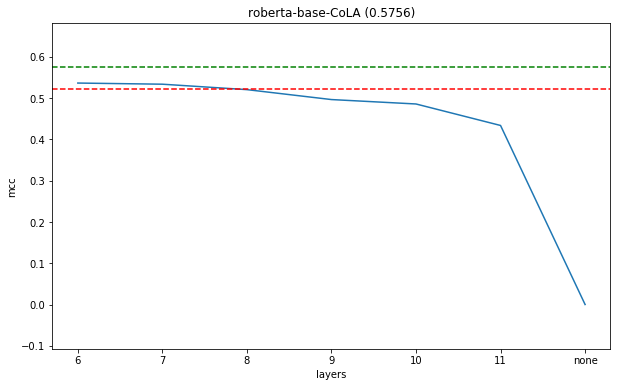

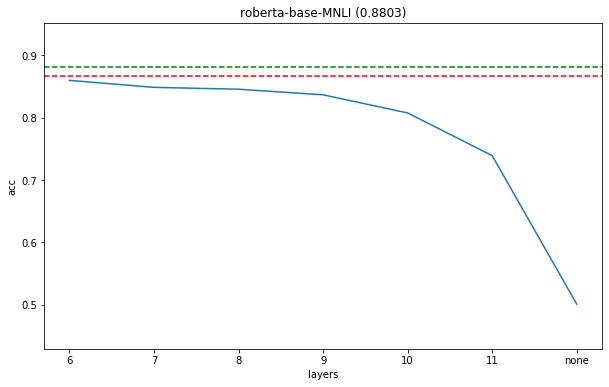

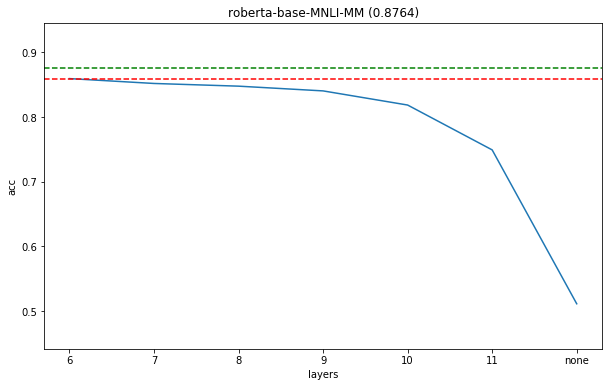

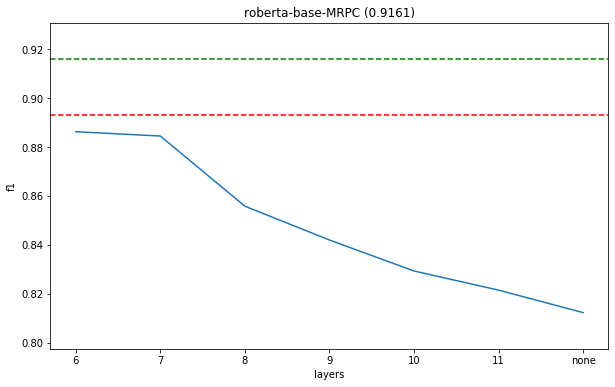

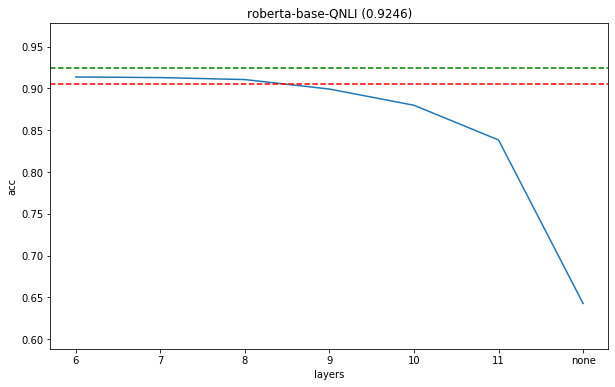

In [35]:
for task in tasks:
    task_results = results[task]
    task_metrics = metrics[task]
    for metric in task_metrics:
        reported = task_results[metric]
        base = task_results[f'base-{metric}']
        draw_graph(task, metric, reported_in_paper[task], base, reported)